In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from influxdb_client import InfluxDBClient, Point, Dialect

import re

import time
import datetime

import warnings
from influxdb_client.client.warnings import MissingPivotFunction

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import matplotlib.colors as colors

# try:
#     # for Python2
#     from Tkinter import *   ## notice capitalized T in Tkinter 
# except ImportError:
#     # for Python3
#     from tkinter import *   ## notice lowercase 't' in tkinter here

pd.set_option('display.max_rows', 100)
import pandasql as ps
import sqlite3

In [118]:
#Read config file and load data into the variables

rx_dict = {
    'token': re.compile(r'var token = "(?P<token>.*)"\n'),
    'url': re.compile(r'var url = "(?P<url>.*)"\n'),
    'org': re.compile(r'var org = "(?P<org>.*)"\n'),
    'bucket': re.compile(r'var bucket = "(?P<bucket>.*)"\n'),
}

def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex

    """
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None



filepath = '/root/flexi-pipe/config.go'
# open the file and read through it line by line
with open(filepath, 'r') as file_object:
    line = file_object.readline()
    while line:
        # at each line check for a match with a regex
        key, match = _parse_line(line)

        if key == 'token':
            token = match.group('token')
        elif key == 'url':
            url = match.group('url')
        elif key == 'org':
            org = match.group('org')
        elif key == 'bucket':
            bucket = match.group('bucket')
        
        line = file_object.readline()


url="http://192.168.20.58:8086"

In [3]:
client = InfluxDBClient(url=url, token=token, org=org,  timeout=30_000)

# write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

In [111]:
# Retrieve experiments data from csv
data = pd.read_csv('./experiments.csv', header=None)
df = pd.DataFrame(data)

#Rename columns
experiments = df.rename(columns={0: "start", 1: "end", 2: "topology", 3: "runtime", 4: "d", 5: "dlo", 6: "dhi", 7: "dscore", 8: "dlazy", 9: "dout", 10: "gossipFactor", 11: "initialDelay", 12: "interval"}, errors='raise')

#Correct timestamp
experiments["start"] = experiments["start"].str.slice(0, 27)
experiments["end"] = experiments["end"].str.slice(0, 27)

#String to timestamp
experiments['startUnix'] = pd.to_datetime(experiments["start"],format="%Y-%m-%d %H:%M:%S.%f").astype('int64') / 10**9
experiments['endUnix'] = pd.to_datetime(experiments["end"],format="%Y-%m-%d %H:%M:%S.%f").astype('int64') / 10**9

experiments['startUnix'] = pd.to_timedelta(experiments['startUnix'], unit='s').dt.total_seconds().astype(int)#.astype(str)
experiments['endUnix'] = pd.to_timedelta(experiments['endUnix'], unit='s').dt.total_seconds().astype(int)#.astype(str)

#Drop fields we don't mneed for the moment
exp = experiments.drop(columns=["runtime", "initialDelay"]).sort_values(by=["start"])

exp.head(100)

,start,end,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,startUnix,endUnix
0,2023-07-21 11:33:25.8681227,2023-07-21 11:48:25.8815367,unl,8,6,12,4,8,2,0.25,0.5,1689939205,1689940105
1,2023-07-21 11:51:57.6626049,2023-07-21 12:06:57.7216522,unl,8,6,12,4,8,2,0.25,0.5,1689940317,1689941217
2,2023-07-21 12:10:30.3045413,2023-07-21 12:25:30.3056339,unl,8,6,12,4,8,2,0.25,0.5,1689941430,1689942330
3,2023-07-21 12:29:02.5299110,2023-07-21 12:44:02.5886491,unl,8,6,12,4,8,2,0.25,1.0,1689942542,1689943442
4,2023-07-21 12:47:35.4834622,2023-07-21 13:02:35.4862777,unl,8,6,12,4,8,2,0.25,1.0,1689943655,1689944555
5,2023-07-21 13:06:08.6071564,2023-07-21 13:21:08.7077403,unl,8,6,12,4,8,2,0.25,1.0,1689944768,1689945668
6,2023-07-21 13:24:41.7356835,2023-07-21 13:39:41.7368319,unl,8,6,12,4,8,2,0.25,30.0,1689945881,1689946781
7,2023-07-21 13:43:15.0470143,2023-07-21 13:58:15.0484766,unl,8,6,12,4,8,2,0.25,30.0,1689946995,1689947895
8,2023-07-21 14:01:48.0040406,2023-07-21 14:16:48.0065267,unl,8,6,12,4,8,2,0.25,30.0,1689948108,1689949008
9,2023-07-21 14:20:21.0317126,2023-07-21 14:35:21.0329588,unl,8,6,12,4,8,2,0.25,3.0,1689949221,1689950121


In [115]:
#Get times for different intervals
# intervals = exp["interval"].drop_duplicates().sort_values().reset_index(drop=True)
# intervals.head(10)

expTime = exp[exp['startUnix'].astype(int).between(1689939205, 1689951448)]
expTime['experiment'] = expTime.index

expTime.head(20)

/tmp/ipykernel_230832/1013435651.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expTime['experiment'] = expTime.index


,start,end,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,startUnix,endUnix,experiment
0,2023-07-21 11:33:25.8681227,2023-07-21 11:48:25.8815367,unl,8,6,12,4,8,2,0.25,0.5,1689939205,1689940105,0
1,2023-07-21 11:51:57.6626049,2023-07-21 12:06:57.7216522,unl,8,6,12,4,8,2,0.25,0.5,1689940317,1689941217,1
2,2023-07-21 12:10:30.3045413,2023-07-21 12:25:30.3056339,unl,8,6,12,4,8,2,0.25,0.5,1689941430,1689942330,2
3,2023-07-21 12:29:02.5299110,2023-07-21 12:44:02.5886491,unl,8,6,12,4,8,2,0.25,1.0,1689942542,1689943442,3
4,2023-07-21 12:47:35.4834622,2023-07-21 13:02:35.4862777,unl,8,6,12,4,8,2,0.25,1.0,1689943655,1689944555,4
5,2023-07-21 13:06:08.6071564,2023-07-21 13:21:08.7077403,unl,8,6,12,4,8,2,0.25,1.0,1689944768,1689945668,5
6,2023-07-21 13:24:41.7356835,2023-07-21 13:39:41.7368319,unl,8,6,12,4,8,2,0.25,30.0,1689945881,1689946781,6
7,2023-07-21 13:43:15.0470143,2023-07-21 13:58:15.0484766,unl,8,6,12,4,8,2,0.25,30.0,1689946995,1689947895,7
8,2023-07-21 14:01:48.0040406,2023-07-21 14:16:48.0065267,unl,8,6,12,4,8,2,0.25,30.0,1689948108,1689949008,8
9,2023-07-21 14:20:21.0317126,2023-07-21 14:35:21.0329588,unl,8,6,12,4,8,2,0.25,3.0,1689949221,1689950121,9


In [113]:
data_frame = query_api.query_data_frame('from(bucket: "gs") '
                                        ' |> range(start: 1689939205, stop:1689952348) '
                                        ' |> filter(fn: (r) => r._measurement == "duplicateMessage") '
                                        ' |> group(columns: ["_measurement", "_field"], mode: "by") '
                                        ' |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")')
client.close()

In [121]:
df = data_frame.drop(columns=['result', 'table','_start', '_stop', '_measurement', 'topic', 'receivedFrom']).sort_values(by=["_time"]).reset_index(drop=True)
df["_time"] = pd.to_datetime(df["_time"])

df.head(10)


,_time,messageID
0,2023-07-21 11:33:26.419229+00:00,ACQIARIgFcrOE6zggqC78TeZqH1n+PmFRXIUXDO+uNuTnL...
1,2023-07-21 11:33:26.419965+00:00,ACQIARIgFcrOE6zggqC78TeZqH1n+PmFRXIUXDO+uNuTnL...
2,2023-07-21 11:33:26.419986+00:00,ACQIARIgFcrOE6zggqC78TeZqH1n+PmFRXIUXDO+uNuTnL...
3,2023-07-21 11:33:26.419990+00:00,ACQIARIgFcrOE6zggqC78TeZqH1n+PmFRXIUXDO+uNuTnL...
4,2023-07-21 11:33:26.420040+00:00,ACQIARIgFcrOE6zggqC78TeZqH1n+PmFRXIUXDO+uNuTnL...
5,2023-07-21 11:33:26.420110+00:00,ACQIARIgFcrOE6zggqC78TeZqH1n+PmFRXIUXDO+uNuTnL...
6,2023-07-21 11:33:26.420152+00:00,ACQIARIgFcrOE6zggqC78TeZqH1n+PmFRXIUXDO+uNuTnL...
7,2023-07-21 11:33:26.420169+00:00,ACQIARIgFcrOE6zggqC78TeZqH1n+PmFRXIUXDO+uNuTnL...
8,2023-07-21 11:33:26.420218+00:00,ACQIARIgFcrOE6zggqC78TeZqH1n+PmFRXIUXDO+uNuTnL...
9,2023-07-21 11:33:26.420222+00:00,ACQIARIgFcrOE6zggqC78TeZqH1n+PmFRXIUXDO+uNuTnL...


In [155]:
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
df.to_sql('df', conn, index=False)
expTime.to_sql('expTime', conn, index=False)

qry = '''
    select  
        df._time,
        df.messageID,
        expTime.experiment,
        expTime.interval
    from
        df join expTime on
        df._time between expTime.start and expTime.end
    '''
dfNew = pd.read_sql_query(qry, conn)

dfNew = dfNew.set_index('experiment').rename(columns={"_time": "min"}).drop(columns=["messageID"])

dfNew['min'] = pd.to_datetime(dfNew["min"], format='mixed')
# dfNew['_min'] = pd.to_datetime(dfNew["_min"])

dfNew.head(20)

,min,interval
experiment,,
0,2023-07-21 11:33:26.419229+00:00,0.5
0,2023-07-21 11:33:26.419965+00:00,0.5
0,2023-07-21 11:33:26.419986+00:00,0.5
0,2023-07-21 11:33:26.419990+00:00,0.5
0,2023-07-21 11:33:26.420040+00:00,0.5
0,2023-07-21 11:33:26.420110+00:00,0.5
0,2023-07-21 11:33:26.420152+00:00,0.5
0,2023-07-21 11:33:26.420169+00:00,0.5
0,2023-07-21 11:33:26.420218+00:00,0.5


In [165]:
#Min datetime of each experiment
minTime = dfNew.groupby(['experiment']).agg('min').drop(columns=['interval'])

# minTime.head(20)

#Join to calculate delta
dfWithMin = dfNew.merge(minTime, on='experiment', how='left').rename(columns={'min_x': '_time', 'min_y': '_min'})


dfWithMin['_time'] = pd.to_datetime(dfWithMin["_time"], format='mixed')
dfWithMin['_min'] = pd.to_datetime(dfWithMin["_min"],  format='mixed')

#Calculate delta in seconds 
dfWithMin["delta"] = ((dfWithMin["_time"] - dfWithMin["_min"]) / pd.Timedelta(seconds=1)).astype(int)

dfWithMin.head(100)

#Aggregate by time
gb = dfWithMin.groupby(['delta','experiment', 'interval']).agg(["count"]).sort_values(by=["experiment", "delta"])
gb.columns = gb.columns.droplevel(0)
gb.reset_index(level=0, inplace=True)

# gb.head(100)

#Average by interval
intv = gb.groupby(['interval','delta']).agg(["mean"]).sort_values(by=["interval", "delta"])
# intv.columns = intv.columns.droplevel(0)
# intv.reset_index(level=0, inplace=True)

intv.head(100)

count             
                       mean         mean
interval delta                          
0.5      0       591.333333   591.333333
         1         6.000000     6.000000
         3       165.000000   165.000000
         4        45.000000    45.000000
         6        75.000000    75.000000
         7       143.000000   143.000000
         10      214.000000   214.000000
         11        6.000000     6.000000
         13      166.000000   166.000000
         14       48.000000    48.000000
         580     100.000000   100.000000
         594      27.000000    27.000000
         595      29.000000    29.000000
         596      10.000000    10.000000
         599      20.000000    20.000000
         600      93.000000    93.000000
         605     682.000000   682.000000
         606    1101.000000  1101.000000
         609      45.000000    45.000000
         610     103.000000   103.000000
         619      25.000000    25.000000
         620     121.000000   121.000000
         625     438.000000   438.000000
         626    1382.000000  1382.000000
         629      46.000000    46.000000
         630     112.000000   112.000000
         639      25.000000    25.000000
         640     126.000000   126.000000
         645     435.000000   435.000000
         646    1376.000000  1376.000000
         649      48.000000    48.000000
         650     102.000000   102.000000
         659      44.000000    44.000000
         660     103.000000   103.000000
         665     436.000000   436.000000
         666    1383.000000  1383.000000
         669      18.000000    18.000000
         670     141.000000   141.000000
         679      47.000000    47.000000
         680     104.000000   104.000000
         685     440.000000   440.000000
         686    1362.000000  1362.000000
         689      13.000000    13.000000
         690     141.000000   141.000000
         699      52.000000    52.000000
         700      98.000000    98.000000
         705     442.000000   442.000000
         706    1380.000000  1380.000000
         709      19.000000    19.000000
         710     135.000000   135.000000
         719      53.000000    53.000000
         720      98.000000    98.000000
         725     441.000000   441.000000
         726    1390.000000  1390.000000
         729      19.000000    19.000000
         730     137.000000   137.000000
         739      48.000000    48.000000
         740     101.000000   101.000000
         745     442.000000   442.000000
         746    1392.000000  1392.000000
         749      63.000000    63.000000
         750      96.000000    96.000000
         759      26.000000    26.000000
         760     118.000000   118.000000
         765     437.000000   437.000000
         766    1384.000000  1384.000000
         769      90.000000    90.000000
         770      67.000000    67.000000
         779      29.000000    29.000000
         780     117.000000   117.000000
         785     206.000000   206.000000
         786    1606.000000  1606.000000
         789      81.000000    81.000000
         790      75.000000    75.000000
         799      56.000000    56.000000
         800      95.000000    95.000000
         805     143.000000   143.000000
         806    1690.000000  1690.000000
         809      81.000000    81.000000
         810      73.000000    73.000000
         819      35.000000    35.000000
         820     115.000000   115.000000
         825     498.000000   498.000000
         826    1322.000000  1322.000000
         829     100.000000   100.000000
         830      43.000000    43.000000
         839      34.000000    34.000000
         840     118.000000   118.000000
         845     509.000000   509.000000
         846    1309.000000  1309.000000
         849     113.000000   113.000000
         850      48.000000    48.000000
         859      51.000000    51.000000
         860      94.000000    94.000000
         865     662.000000   662.000000
    

In [104]:
#get first datetime
delta = df["_time"].min()
# print(delta)

#Calculate delta in seconds 
df["delta"] = ((df["_time"] - delta) / pd.Timedelta(seconds=1)).astype(int)
# print(df.loc[df["delta"] >= 1 & df["delta"] <= 2])

#Aggregate by time
gb = df.groupby(['delta']).agg(["count"]).sort_values(by=["delta"])
gb.columns = gb.columns.droplevel(0)
gb.reset_index(level=0, inplace=True)

gb.tail(100)

,delta,count,count
3108,12979,2649,2649
3109,12981,45,45
3110,12982,2646,2646
3111,12984,46,46
3112,12985,2653,2653
3113,12987,46,46
3114,12988,2648,2648
3115,12990,43,43
3116,12991,2649,2649
3117,12993,48,48


FileNotFoundError: [Errno 2] No such file or directory: './figure/messOverheadInterval.pdf'

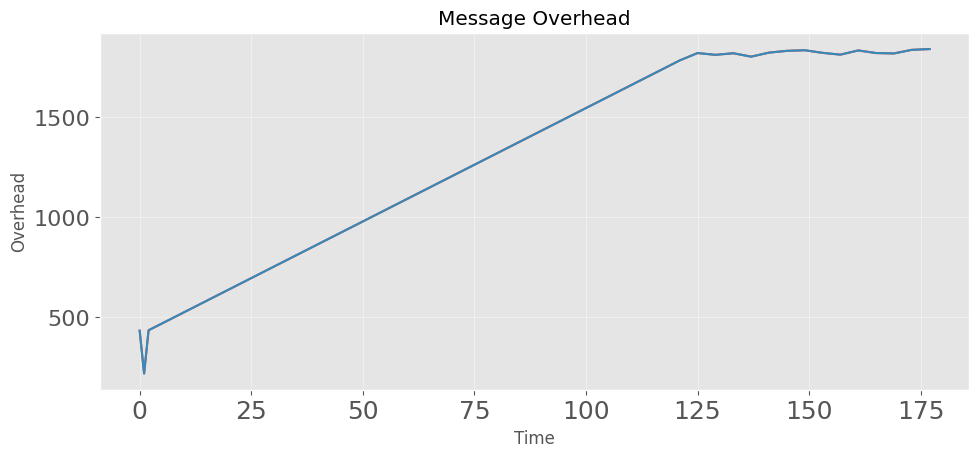

In [97]:
plt.style.use('ggplot')
# kwargs = dict(color=['hotpink'], alpha=0.9)#, density=True)

fig, ax = plt.subplots(constrained_layout=False)
ax.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.gca().set(title='Message Overhead', ylabel='Overhead', xlabel="Time")

plt.rcParams.update({'font.size': 18})
# plt.hist([x1, x2, x6], **kwargs, label=['GS 1 topic', 'Vanilla', 'Squelching'])
# plt.legend(loc='upper center', bbox_to_anchor=(0.58, 1))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

fig.set_size_inches(11, 4.3)

plt.plot(gb["delta"], gb["count"])#, **kwargs)

fig.savefig('./figure/messOverheadInterval.pdf', format='pdf', facecolor='white', edgecolor='none', bbox_inches='tight', dpi=600)
fig.savefig('./figure/messOverheadInterval.png', format='png', facecolor='white', edgecolor='none', bbox_inches='tight', dpi=600)

plt.show()